In [1]:
"""
This module processes precipitation data in GeoTIFF format for use in developing a new drought index.
The module includes functions to read, analyze, and manipulate precipitation data to support the 
calculation of the drought index.

Functions:
    read_geotiff(file_path):
        Reads a GeoTIFF file and returns the data as a NumPy array.
        
    calculate_monthly_precipitation(data):
        Aggregates daily precipitation data into monthly totals.
        
    calculate_drought_index(monthly_precipitation):
        Computes the drought index based on the monthly precipitation data.
        
    save_drought_index(drought_index, output_path):
        Saves the calculated drought index to a specified file path in GeoTIFF format.
        
Usage:
    This module is intended to be used as part of a larger system for drought analysis. 
    It can be imported and its functions called with appropriate parameters to process 
    precipitation data and calculate the drought index.
"""

'\nThis module processes precipitation data in GeoTIFF format for use in developing a new drought index.\nThe module includes functions to read, analyze, and manipulate precipitation data to support the \ncalculation of the drought index.\n\nFunctions:\n    read_geotiff(file_path):\n        Reads a GeoTIFF file and returns the data as a NumPy array.\n        \n    calculate_monthly_precipitation(data):\n        Aggregates daily precipitation data into monthly totals.\n        \n    calculate_drought_index(monthly_precipitation):\n        Computes the drought index based on the monthly precipitation data.\n        \n    save_drought_index(drought_index, output_path):\n        Saves the calculated drought index to a specified file path in GeoTIFF format.\n        \nUsage:\n    This module is intended to be used as part of a larger system for drought analysis. \n    It can be imported and its functions called with appropriate parameters to process \n    precipitation data and calculate th

In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Set data directory
data_dir = "../../datasets/precipitation_chirps/chirps_tif"

In [3]:
# Read AOI vector file

gha_region = "../../datasets/gha/gha.shp"

In [4]:
# Read roi polygon
gha_region = gpd.read_file(gha_region)
gha_region

,OBJECTID,COUNTRY,area,Shape_Leng,Shape_Area,land_under,geometry
0,1,Burundi,0.0,8.560371,2.193095,None,"POLYGON ((30.36003 -2.35343, 30.36209 -2.35250..."
1,2,Djibouti,0.0,7.874779,1.781569,None,"POLYGON ((42.66339 11.07150, 42.65628 11.07671..."
2,3,Eritrea,0.0,41.125347,10.077064,None,"MULTIPOLYGON (((43.14681 12.71384, 43.14167 12..."
3,4,Ethiopia,0.0,49.028874,92.986294,None,"POLYGON ((41.77824 11.54207, 41.77785 11.51077..."
4,5,Kenya,0.0,40.625985,47.319578,None,"MULTIPOLYGON (((39.40283 -4.65471, 39.40523 -4..."
5,6,Rwanda,0.0,8.078222,2.054446,None,"POLYGON ((30.36750 -2.34399, 30.36209 -2.35250..."
6,7,Somalia,0.0,53.331305,51.800944,None,"MULTIPOLYGON (((41.92670 -1.16192, 41.92260 -1..."
7,8,Tanzania,0.0,57.988209,77.546629,None,"MULTIPOLYGON (((40.42789 -10.38034, 40.42349 -..."
8,9,South Sudan,0.0,46.515148,51.867644,None,"POLYGON ((31.79577 3.82198, 31.79585 3.82126, ..."
9,10,Sudan,0.0,73.448957,158.194024,930459.06\r\n930459,"POLYGON ((24.32633 16.51445, 23.99918 16.50046..."


In [ ]:
# # Extract files 
# chirps_gz_folder = os.path.join(data_dir, 'precipitation_chirps')
# output_folder = os.path.join(data_dir, "precipitation_chirps\chirps_tif")

# # Decompress all .gz files
# for gz_file in os.listdir(chirps_gz_folder):
#     if gz_file.endswith(".gz"):
#         with gzip.open(os.path.join(chirps_gz_folder, gz_file), 'rb') as f_in:
#             with open(os.path.join(data_dir, gz_file[:-3]), 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
# print("Decompression complete!")


## Precipitation pre-processing

### Read precipitation file

In [5]:
# Read precipitation data
precip_chrips = xr.open_dataset('../../datasets/precipitation_chirps/precip_chirps.nc')
precip_chrips

/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'gsmv6' loading failed:
No module named 'shxarray.shlib'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'icgem' loading failed:
No module named 'shxarray.shlib'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'shascii' loading failed:
No module named 'shxarray.shlib'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:        (x: 1500, y: 1600, time: 250)
Coordinates:
    band           int64 ...
  * x              (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
  * y              (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Data variables:
    spatial_ref    int64 ...
    precipitation  (time, y, x) float32 ...

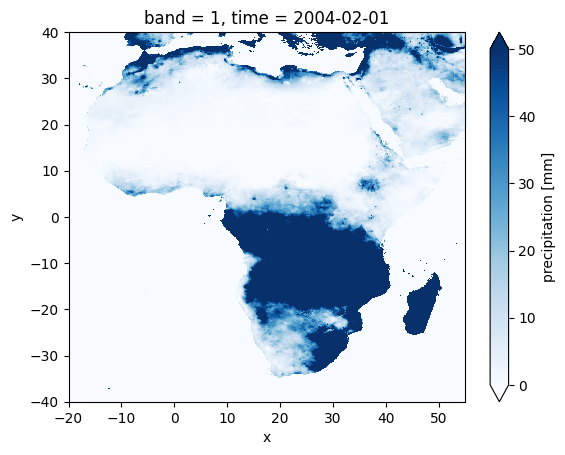

In [6]:
# Plot one month

sample_data = precip_chrips['precipitation'].isel(time=slice(1,5)).isel(time=0)
sample_data.plot(vmin=0, vmax=50, cmap="Blues")

### Clip the study area

In [7]:
# Set spatial dimensions and CRS
data = precip_chrips.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
data = data.rio.write_crs("epsg:4326", inplace=True)

# Load the shapefile using geopandas
gdf = gha_region.to_crs(data.rio.crs)

# Extract geometries from the GeoDataFrame
geometries = gdf.geometry

# Clip the dataset using the geometries
precipitaion_gha = data.rio.clip(geometries, gdf.crs)

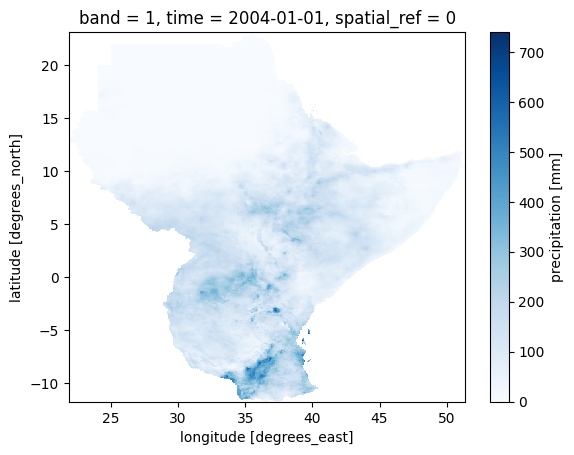

In [8]:
# Visualize sample 
sample_gha = precipitaion_gha['precipitation'].isel(time=0)
sample_gha.plot( cmap="Blues")

In [32]:
attr = list(precipitaion_gha.data_vars)
for var in attr:
    # print (var)
    del precipitaion_gha.data_vars[var].attrs['grid_mapping']

In [33]:
# Export precipitation data for GHA
precipitaion_gha.to_netcdf('../../datasets/precipitation_chirps/precip_chirps_gha.nc')

#### Read GHA dataset

In [34]:
# Read precipitation data
precipitation_gha = xr.open_dataset('../../datasets/precipitation_chirps/precip_chirps_gha.nc')
precipitation_gha

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 250)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Data variables:
    spatial_ref    int64 ...
    precipitation  (time, y, x) float32 ...

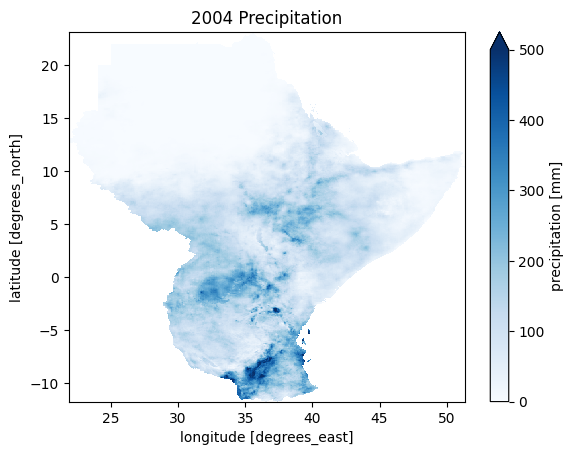

In [36]:
# Visualize sample year
sample_precip_gha = precipitation_gha['precipitation'].isel(time=0)
sample_precip_gha.plot(vmax=500, cmap="Blues")
plt.title('2004 Precipitation')
plt.show()

### Calculate baseline average

#### Process climatology

In [37]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_gha.groupby("time.month").mean("time")

In [38]:
precipitation_clim

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, month: 12)
Coordinates:
    band           int64 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (month) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precipitation  (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan

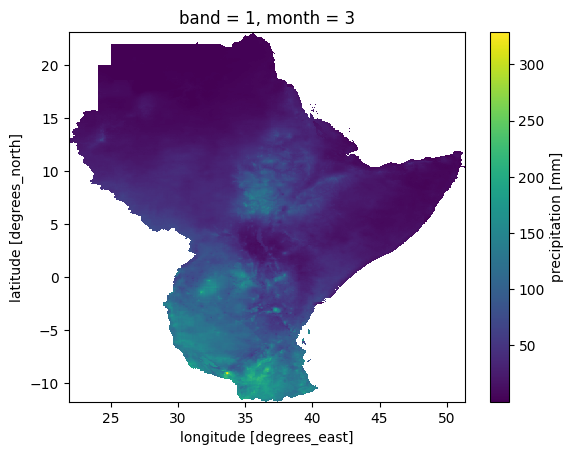

In [48]:
precipitation_clim['precipitation'].isel(month=2).plot()

In [49]:
# Calculate anomalies
precipitation_anomalies = precipitation_gha.groupby("time.month") - precipitation_clim

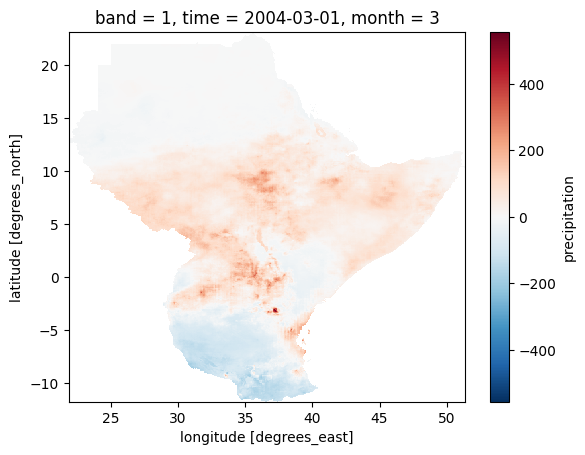

In [55]:
precipitation_anomalies['precipitation'].isel(time=2).plot()

### Standardize the anomalies

In [56]:
# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_gha.groupby("time.month").std("time")

# Calculate standardized anomalies
standardized_anomalies = precipitation_anomalies / precipitation_std

(array([2.79000e+02, 3.70200e+03, 1.78083e+06, 6.75917e+05, 1.15770e+04,
        1.07500e+03, 2.50000e+02, 1.02000e+02, 3.00000e+01, 1.40000e+01]),
 array([-9.53831387, -5.94015932, -2.3420043 ,  1.25615036,  4.85430527,
         8.45245934, 12.05061436, 15.64876938, 19.24692345, 22.84507942,
        26.44323349]),
 <BarContainer object of 10 artists>)

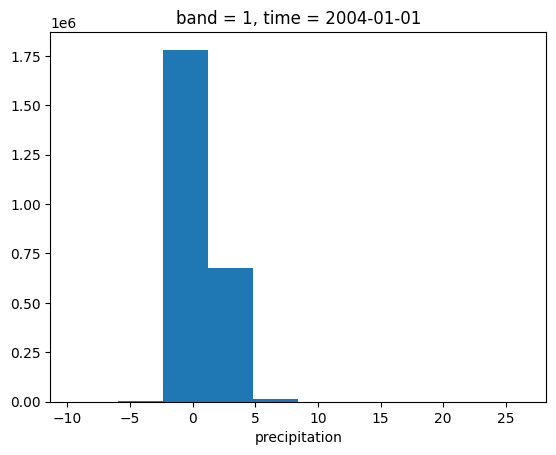

In [59]:
# Plot standardized anomalies for a sample month
sample_standardized_anomalies = standardized_anomalies.isel(time=0)
sample_standardized_anomalies['precipitation'].plot()

#### TODO

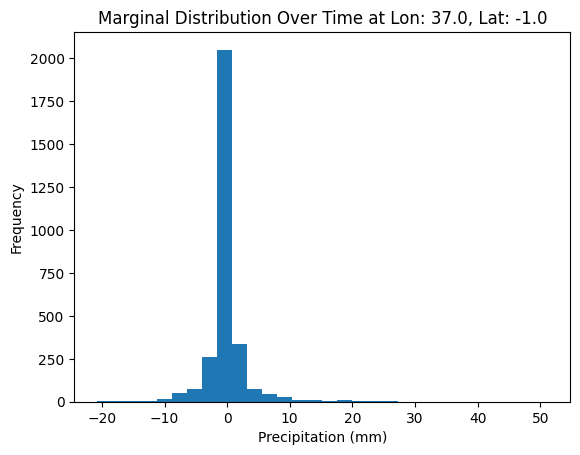

In [89]:
# TODO: Implement fitting marginal distribution to the data

# Select a specific location
lon, lat = 37.0, -1.0  # Example coordinates

# Extract time series for the location
time_series = standardized_anomalies.sel(x=lon, y=lat, method="nearest")

# Plot histogram (marginal distribution over time)
time_series.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Time at Lon: {lon}, Lat: {lat}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()



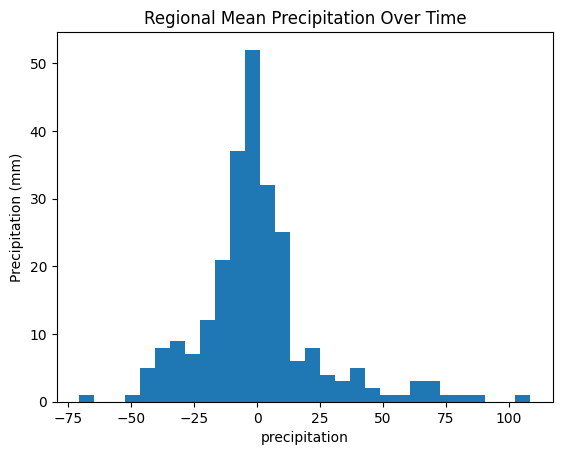

In [91]:
# Subset data for a bounding box (e.g., Greater Horn of Africa)
region = precipitation_anomalies.sel(x=slice(33, 43), y=slice(5, -5))

# Calculate mean precipitation over space or time within the region
region_mean_time = region.mean(dim=["x", "y"])
region_mean_time.plot.hist(bins=30)
plt.title("Regional Mean Precipitation Over Time")
plt.ylabel("Precipitation (mm)")
plt.show()


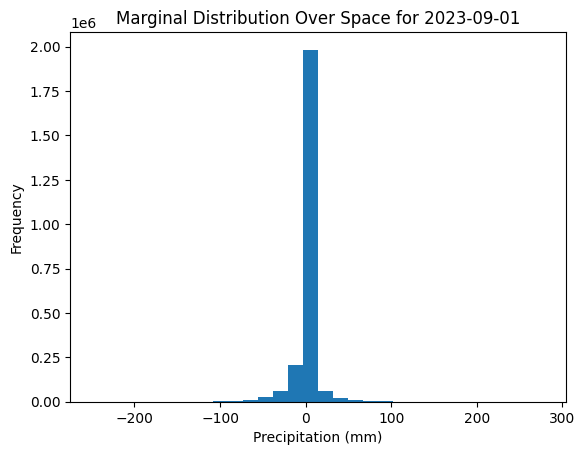

In [93]:
# Select a specific time point
specific_time = "2023-09-01"

# Extract spatial precipitation data
spatial_data = precipitation_anomalies.sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


In [66]:
# Check for non-finite values
non_finite = np.isnan(standardized_anomalies['precipitation']) | np.isinf(standardized_anomalies['precipitation'])
print(non_finite.sum())  # Number of non-finite values

<xarray.DataArray 'precipitation' ()>
array(619110000)


In [69]:
standardized_anomalies['precipitation']

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    band     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [67]:
# Remove non-finite values
clean_data = standardized_anomalies['precipitation'].where(standardized_anomalies['precipitation'].notnull(), drop=True)
shape, loc, scale = stats.gamma.fit(clean_data.values.ravel(), floc=0)

RuntimeError: The data contains non-finite values.

In [73]:
clean_data = standardized_anomalies['precipitation'].where(~non_finite, drop=True)

In [75]:
precipitation = clean_data.fillna(0)  # Replace NaN with 0
precipitation = xr.where(np.isinf(precipitation), 0, precipitation)  # Replace inf with 0

In [88]:
precipitation

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591, month: 12)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)
Coordinates:
    band     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
# Replace non-finite with a specific value (e.g., 0 for no precipitation)
standardized_anomalies['precipitation'] = standardized_anomalies['precipitation'].fillna(0)
shape, loc, scale = stats.gamma.fit(standardized_anomalies['precipitation'].values.ravel(), floc=0)

In [87]:
shape, loc, scale = stats.gamma.fit(precipitation[:100].values, floc=0)

FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'gamma' requires that 0 < (x - loc)/scale  < inf for each x in `data`.

In [86]:
shape, loc, scale = stats.norm.fit(precipitation.values)

RuntimeError: The data contains non-finite values.

In [163]:
shape, loc = stats.norm.fit(precipitation.values.ravel())

In [165]:
shape

-1.6694951e-08

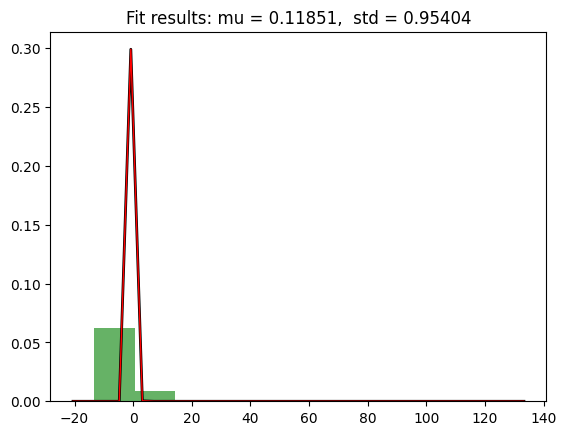

In [170]:
data = precipitation.values.ravel()
plt.hist(data, bins=10, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 40)
p = stats.norm.pdf(x, shape, loc)
q = stats.norm.pdf(x, shape, loc)
plt.plot(x, p, 'k', linewidth=2)
plt.plot(x, q, 'r', linewidth=1)
title = "Fit results: mu = %.5f,  std = %.5f" % (mu, std)
plt.title(title)

plt.show()

In [92]:
log_precip = np.log(precipitation[:100])
mean_log = np.mean(log_precip)
std_log = np.std(log_precip)

# Transform the data to have mean 0 and variance 1
transformed_data = (log_precip - mean_log) / std_log

# Now transformed_data should approximately follow a normal distribution

# Fit a normal distribution to the transformed data
normal_dist = stats.norm.fit(transformed_data.values.ravel())

/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/jovyan/.local/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


RuntimeError: The data contains non-finite values.

0.11850753582467491
0.9540396685619056


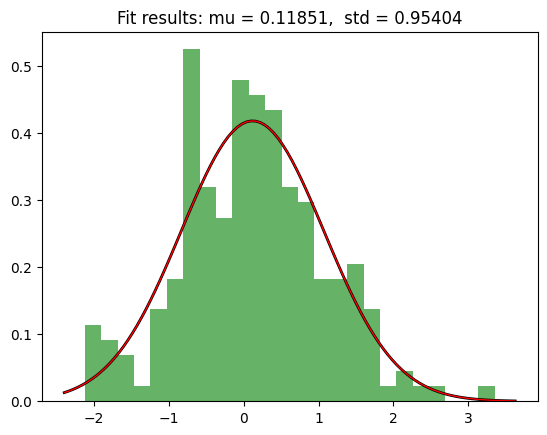

In [134]:
data = stats.norm.rvs(loc=0,scale=1,size=200)

mu1 = np.mean(data)

std1 = np.std(data)

print(mu1)
print(std1)

mu, std = stats.norm.fit(data)

plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
q = stats.norm.pdf(x, mu1, std1)
plt.plot(x, p, 'k', linewidth=2)
plt.plot(x, q, 'r', linewidth=1)
title = "Fit results: mu = %.5f,  std = %.5f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
# TODO: Transform data to uniform margins
